# Task Classification - Exploratory Data Analysis
# Goal: Analyze data for classifying task descriptions into categories and priorities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

print("Task Classification EDA - Analyzing Data for ML Classification")
print("="*70)

# Load the datasets
tasks_df = pd.read_csv('tasks_dataset.csv')
employees_df = pd.read_csv('employees_dataset.csv')

print(f"Dataset Overview:")
print(f"Tasks: {tasks_df.shape[0]} rows, {tasks_df.shape[1]} columns")
print(f"Employees: {employees_df.shape[0]} rows, {employees_df.shape[1]} columns")
print()

# Display basic info
print("Tasks Dataset Info:")
print(tasks_df.info())
print("\nEmployees Dataset Info:")
print(employees_df.info())

# Check for missing values
print("\nMissing Values Analysis:")
print("Tasks dataset missing values:")
print(tasks_df.isnull().sum())
print("\nEmployees dataset missing values:")
print(employees_df.isnull().sum())

Task Classification EDA - Analyzing Data for ML Classification
Dataset Overview:
Tasks: 450 rows, 5 columns
Employees: 100 rows, 3 columns

Tasks Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   taskid                  450 non-null    object
 1   task_description        450 non-null    object
 2   priority                450 non-null    object
 3   category                450 non-null    object
 4   assigned_to_employeeid  450 non-null    object
dtypes: object(5)
memory usage: 17.7+ KB
None

Employees Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   emp_id                  100 non-null    object
 1   emp_load                100 non-null 

# 1. TARGET VARIABLE ANALYSIS (CLASSIFICATION GOALS)

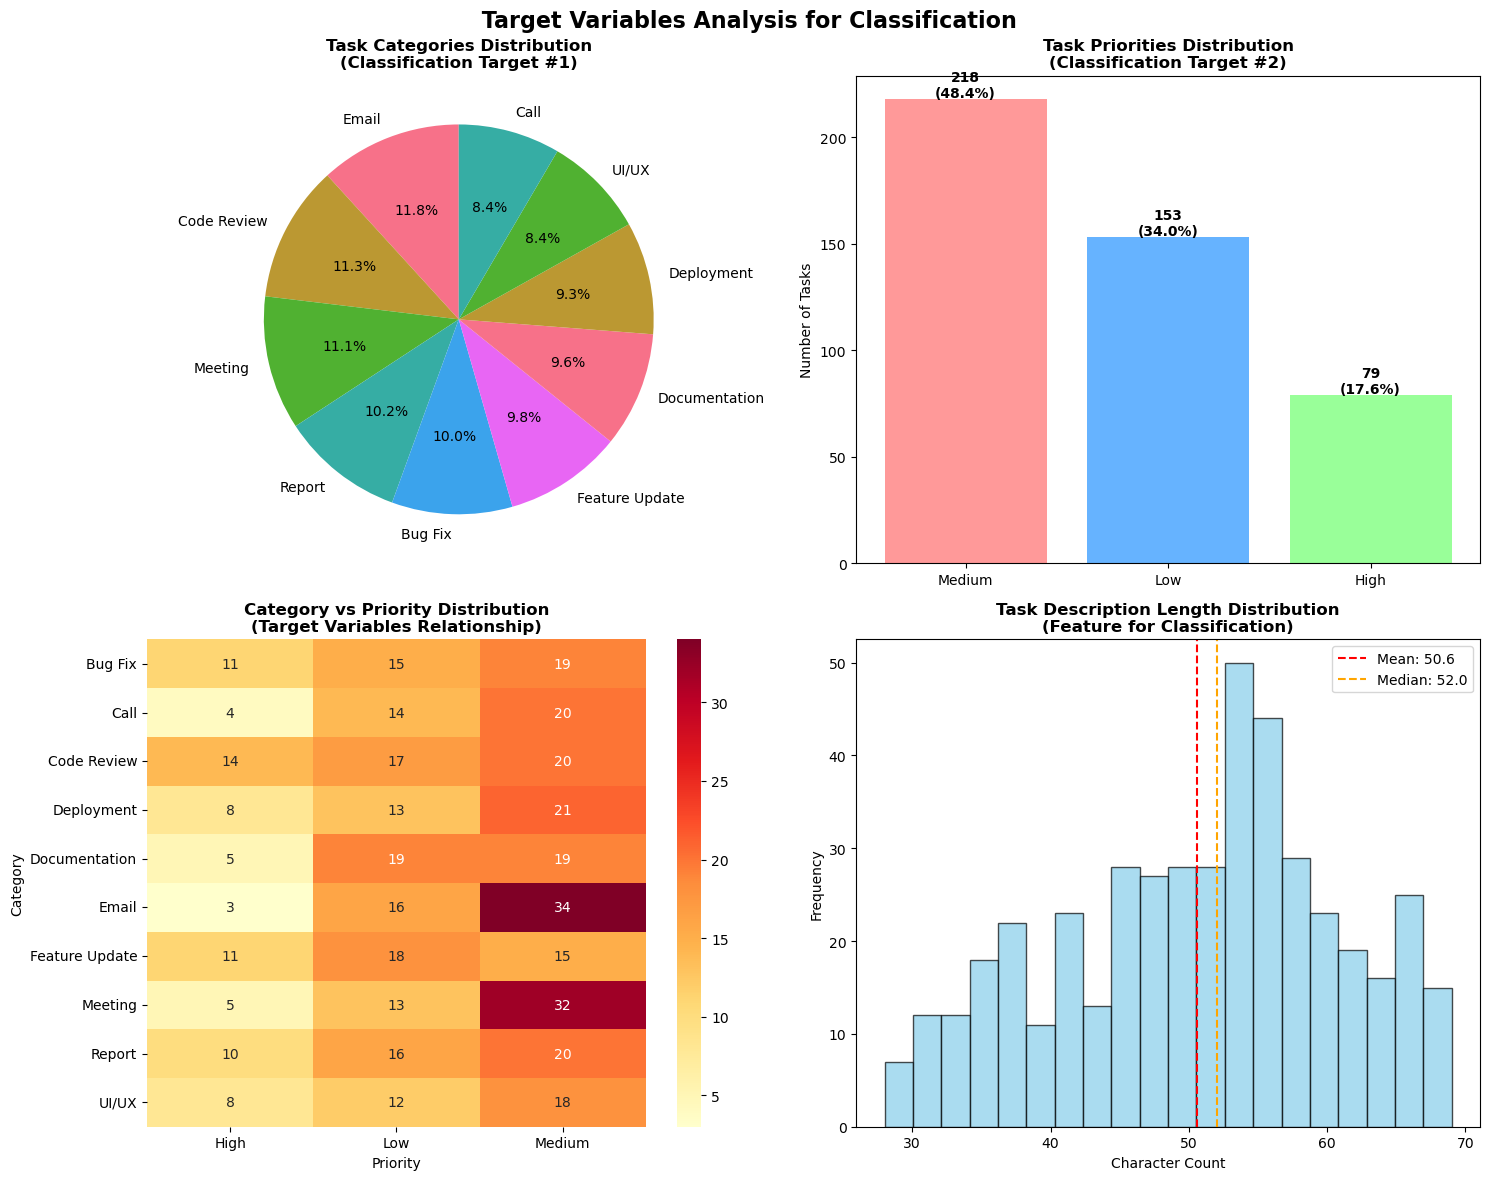


Target Variable Statistics:
Categories: 10 unique categories
Priorities: 3 unique priorities
Category distribution:
category
Email             53
Code Review       51
Meeting           50
Report            46
Bug Fix           45
Feature Update    44
Documentation     43
Deployment        42
UI/UX             38
Call              38
Name: count, dtype: int64

Priority distribution:
priority
Medium    218
Low       153
High       79
Name: count, dtype: int64


In [2]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(' Target Variables Analysis for Classification', fontsize=16, fontweight='bold')

# Category Distribution
category_counts = tasks_df['category'].value_counts()
ax1.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Task Categories Distribution\n(Classification Target #1)', fontweight='bold')

# Priority Distribution
priority_counts = tasks_df['priority'].value_counts()
colors_priority = ['#ff9999', '#66b3ff', '#99ff99']
ax2.bar(priority_counts.index, priority_counts.values, color=colors_priority)
ax2.set_title('Task Priorities Distribution\n(Classification Target #2)', fontweight='bold')
ax2.set_ylabel('Number of Tasks')
for i, v in enumerate(priority_counts.values):
    ax2.text(i, v + 1, f'{v}\n({v/len(tasks_df)*100:.1f}%)', ha='center', fontweight='bold')

# Category vs Priority Heatmap
priority_category_crosstab = pd.crosstab(tasks_df['category'], tasks_df['priority'])
sns.heatmap(priority_category_crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax3)
ax3.set_title('Category vs Priority Distribution\n(Target Variables Relationship)', fontweight='bold')
ax3.set_xlabel('Priority')
ax3.set_ylabel('Category')

# Task Description Length Distribution
desc_lengths = tasks_df['task_description'].str.len()
ax4.hist(desc_lengths, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(desc_lengths.mean(), color='red', linestyle='--', label=f'Mean: {desc_lengths.mean():.1f}')
ax4.axvline(desc_lengths.median(), color='orange', linestyle='--', label=f'Median: {desc_lengths.median():.1f}')
ax4.set_title('Task Description Length Distribution\n(Feature for Classification)', fontweight='bold')
ax4.set_xlabel('Character Count')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nTarget Variable Statistics:")
print(f"Categories: {tasks_df['category'].nunique()} unique categories")
print(f"Priorities: {tasks_df['priority'].nunique()} unique priorities")
print(f"Category distribution:\n{category_counts}")
print(f"\nPriority distribution:\n{priority_counts}")

# 2. TEXT ANALYSIS FOR CLASSIFICATION



 TEXT ANALYSIS - Key for Classification Success
 TOP KEYWORDS BY CATEGORY (Classification Features):
--------------------------------------------------

EMAIL:
  • 'project': 17 times (32.1% of tasks)
  • 'compose': 17 times (32.1% of tasks)
  • 'client': 17 times (32.1% of tasks)
  • 'communication': 17 times (32.1% of tasks)
  • 'regarding': 17 times (32.1% of tasks)

FEATURE UPDATE:
  • 'functionality': 19 times (43.2% of tasks)
  • 'add': 11 times (25.0% of tasks)
  • 'notification': 11 times (25.0% of tasks)
  • 'system': 11 times (25.0% of tasks)
  • 'application': 11 times (25.0% of tasks)

DOCUMENTATION:
  • 'update': 18 times (41.9% of tasks)
  • 'documentation': 14 times (32.6% of tasks)
  • 'create': 13 times (30.2% of tasks)
  • 'user': 13 times (30.2% of tasks)
  • 'manual': 13 times (30.2% of tasks)

UI/UX:
  • 'design': 14 times (36.8% of tasks)
  • 'updated': 12 times (31.6% of tasks)
  • 'requirements': 12 times (31.6% of tasks)
  • 'phase': 11 times (28.9% of tasks)


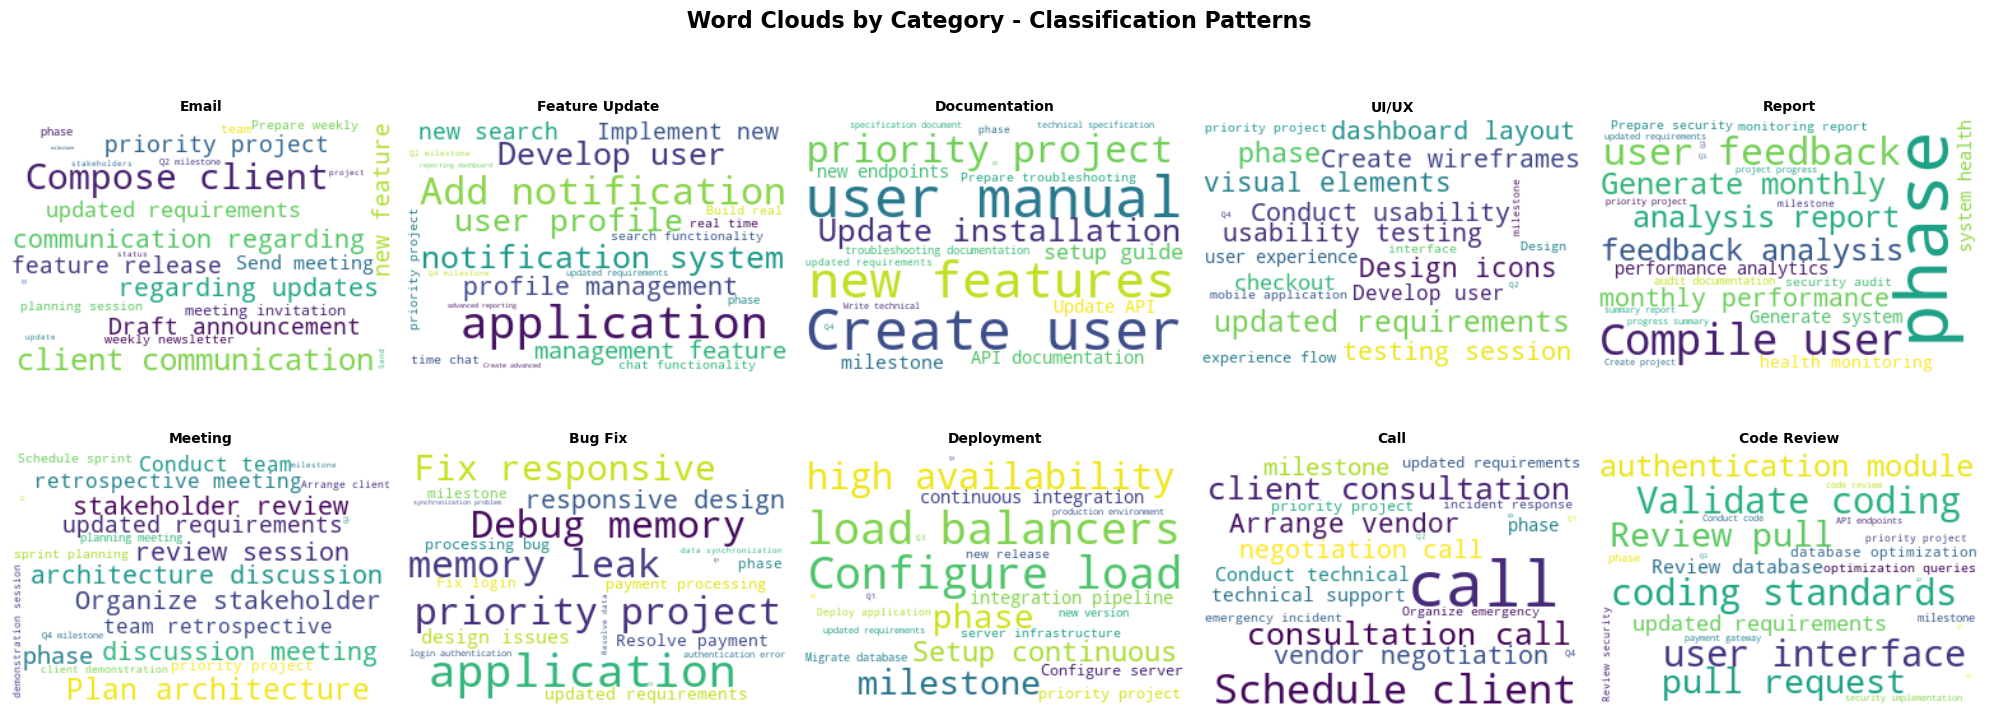

In [3]:
print("\n" + "="*70)
print(" TEXT ANALYSIS - Key for Classification Success")
print("="*70)

# Function to clean and extract keywords
def extract_keywords(text):
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Split and filter words
    words = [word for word in text.split() if len(word) > 2]
    # Remove common stop words
    stop_words = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 
                  'can', 'had', 'her', 'was', 'one', 'our', 'out', 'day', 
                  'get', 'has', 'him', 'his', 'how', 'man', 'new', 'now', 
                  'old', 'see', 'two', 'way', 'who', 'its', 'did', 'yes', 
                  'she', 'may', 'say', 'with', 'from', 'will', 'would'}
    return [word for word in words if word not in stop_words]

# Analyze keywords by category - CRUCIAL FOR CLASSIFICATION
print(" TOP KEYWORDS BY CATEGORY (Classification Features):")
print("-" * 50)

categories = tasks_df['category'].unique()
category_keywords = {}

for category in categories:
    category_tasks = tasks_df[tasks_df['category'] == category]['task_description']
    all_words = []
    for desc in category_tasks:
        all_words.extend(extract_keywords(desc))
    
    word_counts = Counter(all_words)
    top_5_words = word_counts.most_common(5)
    category_keywords[category] = top_5_words
    
    print(f"\n{category.upper()}:")
    for word, count in top_5_words:
        percentage = (count / len(category_tasks)) * 100
        print(f"  • '{word}': {count} times ({percentage:.1f}% of tasks)")

# Create word clouds for visual representation
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle(' Word Clouds by Category - Classification Patterns', fontsize=16, fontweight='bold')

for i, category in enumerate(categories):
    row = i // 5
    col = i % 5
    
    category_text = ' '.join(tasks_df[tasks_df['category'] == category]['task_description'])
    
    # Generate word cloud
    wordcloud = WordCloud(width=300, height=200, background_color='white', 
                         max_words=50, colormap='viridis').generate(category_text)
    
    axes[row, col].imshow(wordcloud, interpolation='bilinear')
    axes[row, col].set_title(f'{category}', fontweight='bold', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# 3. PRIORITY PATTERNS ANALYSIS


 PRIORITY PATTERNS - Classification Insights

LOW PRIORITY - Top Keywords:
  • 'phase': 33 times (21.6% of tasks)
  • 'project': 32 times (20.9% of tasks)
  • 'priority': 27 times (17.6% of tasks)
  • 'milestone': 25 times (16.3% of tasks)
  • 'updated': 25 times (16.3% of tasks)

HIGH PRIORITY - Top Keywords:
  • 'project': 21 times (26.6% of tasks)
  • 'priority': 20 times (25.3% of tasks)
  • 'updated': 19 times (24.1% of tasks)
  • 'requirements': 19 times (24.1% of tasks)
  • 'phase': 17 times (21.5% of tasks)

MEDIUM PRIORITY - Top Keywords:
  • 'updated': 47 times (21.6% of tasks)
  • 'requirements': 47 times (21.6% of tasks)
  • 'project': 46 times (21.1% of tasks)
  • 'milestone': 43 times (19.7% of tasks)
  • 'priority': 41 times (18.8% of tasks)

 Priority Indicator Analysis:
Tasks with high priority indicators: 88
Tasks with low priority indicators: 0

 EMPLOYEE ANALYSIS - Assignment Patterns


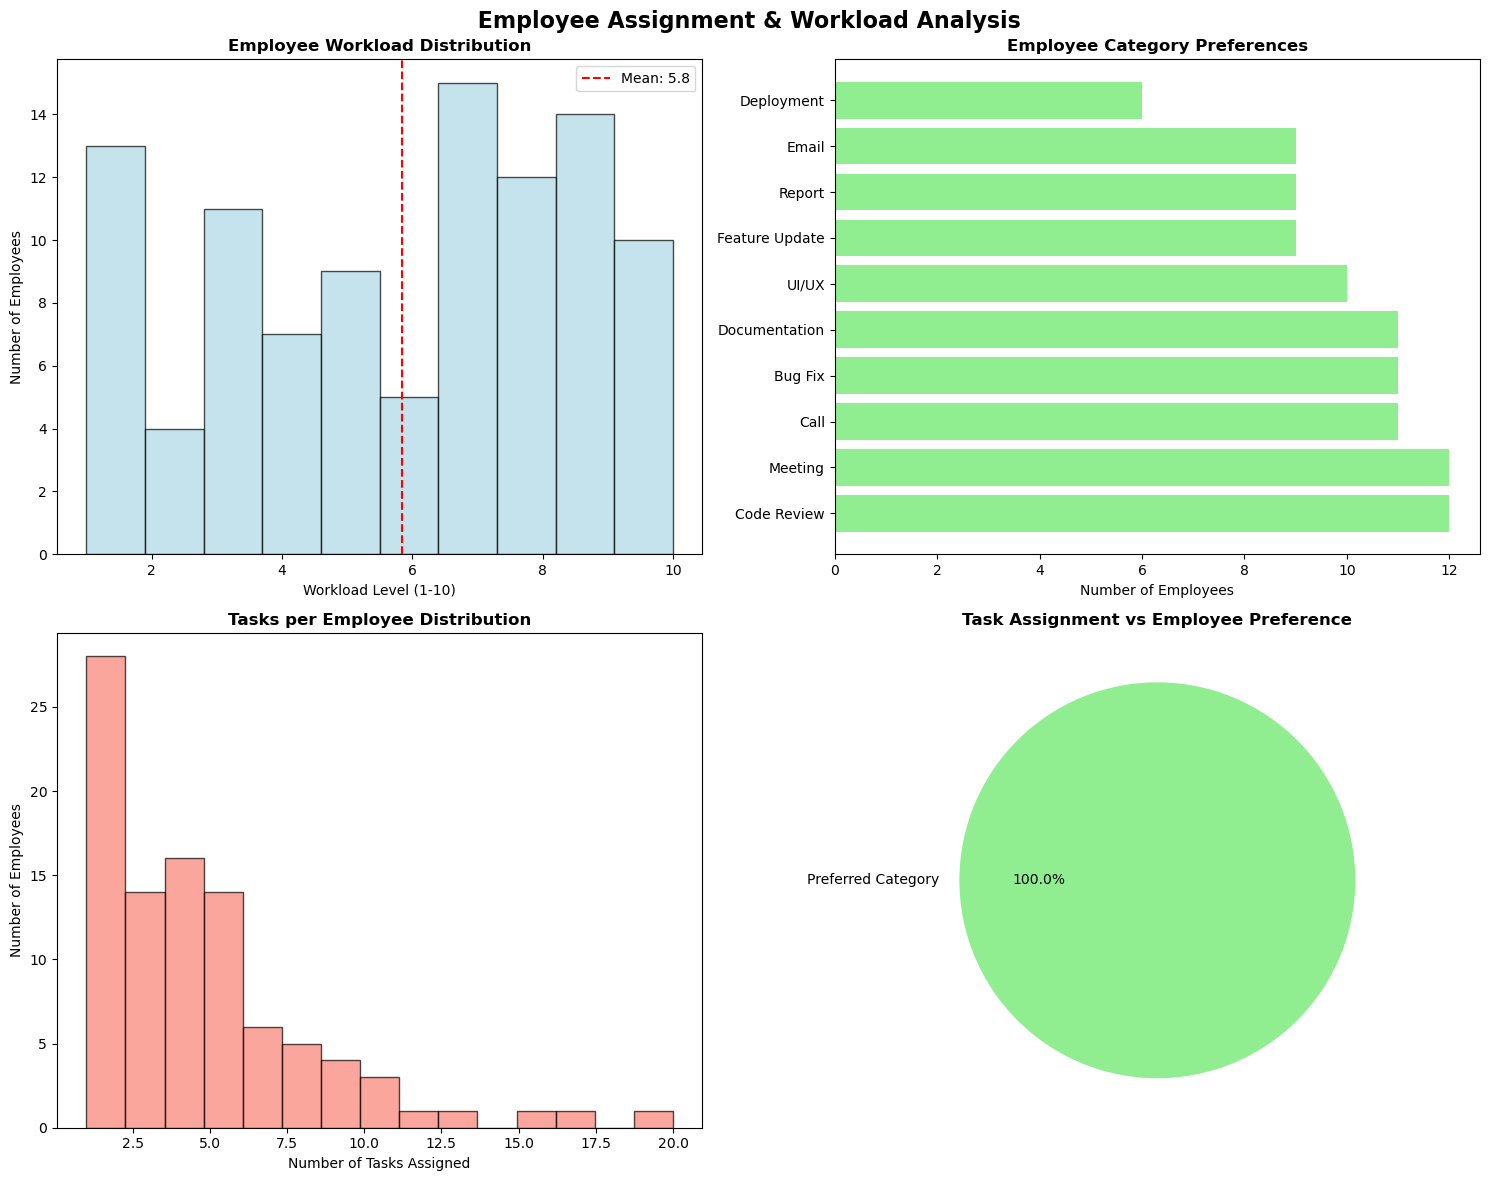

In [4]:
print("\n" + "="*70)
print(" PRIORITY PATTERNS - Classification Insights")
print("="*70)

# Analyze text patterns by priority
priority_keywords = {}
for priority in tasks_df['priority'].unique():
    priority_tasks = tasks_df[tasks_df['priority'] == priority]['task_description']
    all_words = []
    for desc in priority_tasks:
        all_words.extend(extract_keywords(desc))
    
    word_counts = Counter(all_words)
    top_5_words = word_counts.most_common(5)
    priority_keywords[priority] = top_5_words
    
    print(f"\n{priority.upper()} PRIORITY - Top Keywords:")
    for word, count in top_5_words:
        percentage = (count / len(priority_tasks)) * 100
        print(f"  • '{word}': {count} times ({percentage:.1f}% of tasks)")

# Priority indicators analysis
priority_indicators = {
    'high_indicators': ['urgent', 'priority', 'critical', 'asap', 'immediate'],
    'low_indicators': ['when possible', 'eventually', 'low priority', 'routine']
}

# Check for priority indicators in descriptions
tasks_df['has_high_indicators'] = tasks_df['task_description'].str.lower().str.contains('|'.join(priority_indicators['high_indicators']))
tasks_df['has_low_indicators'] = tasks_df['task_description'].str.lower().str.contains('|'.join(priority_indicators['low_indicators']))

print(f"\n Priority Indicator Analysis:")
print(f"Tasks with high priority indicators: {tasks_df['has_high_indicators'].sum()}")
print(f"Tasks with low priority indicators: {tasks_df['has_low_indicators'].sum()}")

# ===============================
# 4. EMPLOYEE WORKLOAD & ASSIGNMENT ANALYSIS
# ===============================

print("\n" + "="*70)
print(" EMPLOYEE ANALYSIS - Assignment Patterns")
print("="*70)

# Merge datasets for comprehensive analysis
task_employee_df = tasks_df.merge(employees_df, left_on='assigned_to_employeeid', right_on='emp_id', how='left')

# Employee workload vs task assignment
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(' Employee Assignment & Workload Analysis', fontsize=16, fontweight='bold')

# Workload distribution
ax1.hist(employees_df['emp_load'], bins=10, alpha=0.7, color='lightblue', edgecolor='black')
ax1.set_title('Employee Workload Distribution', fontweight='bold')
ax1.set_xlabel('Workload Level (1-10)')
ax1.set_ylabel('Number of Employees')
ax1.axvline(employees_df['emp_load'].mean(), color='red', linestyle='--', label=f'Mean: {employees_df["emp_load"].mean():.1f}')
ax1.legend()

# Employee preferred categories
emp_pref_counts = employees_df['emp_preferred_category'].value_counts()
ax2.barh(emp_pref_counts.index, emp_pref_counts.values, color='lightgreen')
ax2.set_title('Employee Category Preferences', fontweight='bold')
ax2.set_xlabel('Number of Employees')

# Tasks per employee
tasks_per_emp = tasks_df['assigned_to_employeeid'].value_counts()
ax3.hist(tasks_per_emp.values, bins=15, alpha=0.7, color='salmon', edgecolor='black')
ax3.set_title('Tasks per Employee Distribution', fontweight='bold')
ax3.set_xlabel('Number of Tasks Assigned')
ax3.set_ylabel('Number of Employees')

# Category vs Employee Preference Match
# Check if employees work on their preferred categories
if not task_employee_df['emp_preferred_category'].isna().all():
    # Create boolean mask for preference matching
    preference_match = task_employee_df['category'] == task_employee_df['emp_preferred_category']
    
    # Count matches and non-matches, handling NaN values
    matches = preference_match.sum()
    total_valid = preference_match.notna().sum()
    non_matches = total_valid - matches
    
    # Only create pie chart if we have data
    if total_valid > 0:
        values = [non_matches, matches]
        labels = ['Different Category', 'Preferred Category']
        colors = ['lightcoral', 'lightgreen']
        
        # Filter out zero values and corresponding labels
        filtered_data = [(val, label, color) for val, label, color in zip(values, labels, colors) if val > 0]
        
        if len(filtered_data) > 0:
            values_filtered, labels_filtered, colors_filtered = zip(*filtered_data)
            ax4.pie(values_filtered, labels=labels_filtered, autopct='%1.1f%%', colors=colors_filtered)
            ax4.set_title('Task Assignment vs Employee Preference', fontweight='bold')
        else:
            ax4.text(0.5, 0.5, 'No preference data available', ha='center', va='center', transform=ax4.transAxes)
            ax4.set_title('Task Assignment vs Employee Preference', fontweight='bold')
    else:
        ax4.text(0.5, 0.5, 'No valid preference data', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Task Assignment vs Employee Preference', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Employee preference data not available', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Task Assignment vs Employee Preference', fontweight='bold')


plt.tight_layout()
plt.show()

# 5. CLASSIFICATION READINESS ASSESSMENT

In [5]:
print("\n" + "="*70)
print(" CLASSIFICATION READINESS ASSESSMENT")
print("="*70)

# Calculate key metrics for classification
def assess_classification_readiness():
    print(" CLASSIFICATION READINESS REPORT:")
    print("-" * 40)
    
    # 1. Target Variable Balance
    category_balance = tasks_df['category'].value_counts()
    category_balance_ratio = category_balance.min() / category_balance.max()
    
    priority_balance = tasks_df['priority'].value_counts()
    priority_balance_ratio = priority_balance.min() / priority_balance.max()
    
    print(f" Category Balance Ratio: {category_balance_ratio:.2f} (closer to 1.0 is better)")
    print(f" Priority Balance Ratio: {priority_balance_ratio:.2f}")
    
    # 2. Text Feature Quality
    avg_desc_length = tasks_df['task_description'].str.len().mean()
    unique_words_per_category = {}
    
    for category in categories:
        category_tasks = tasks_df[tasks_df['category'] == category]['task_description']
        category_words = set()
        for desc in category_tasks:
            category_words.update(extract_keywords(desc))
        unique_words_per_category[category] = len(category_words)
    
    avg_unique_words = np.mean(list(unique_words_per_category.values()))
    
    print(f" Average Description Length: {avg_desc_length:.1f} characters")
    print(f" Average Unique Words per Category: {avg_unique_words:.1f}")
    
    # 3. Feature Distinctiveness
    print(f" Categories with Distinctive Keywords: {len(category_keywords)}/10")
    print(f" Priority Levels: {tasks_df['priority'].nunique()} (Good for multi-class)")
    
    # 4. Data Quality
    missing_data_percentage = (tasks_df.isnull().sum().sum() / (tasks_df.shape[0] * tasks_df.shape[1])) * 100
    print(f" Missing Data: {missing_data_percentage:.1f}%")


assess_classification_readiness()


 CLASSIFICATION READINESS ASSESSMENT
 CLASSIFICATION READINESS REPORT:
----------------------------------------
 Category Balance Ratio: 0.72 (closer to 1.0 is better)
 Priority Balance Ratio: 0.36
 Average Description Length: 50.6 characters
 Average Unique Words per Category: 24.6
 Categories with Distinctive Keywords: 10/10
 Priority Levels: 3 (Good for multi-class)
 Missing Data: 0.0%
